In [203]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from datetime import datetime

In [204]:
df = pd.read_csv('london.csv', parse_dates=['timestamp'])

In [205]:
df.shape

(17414, 10)

In [206]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


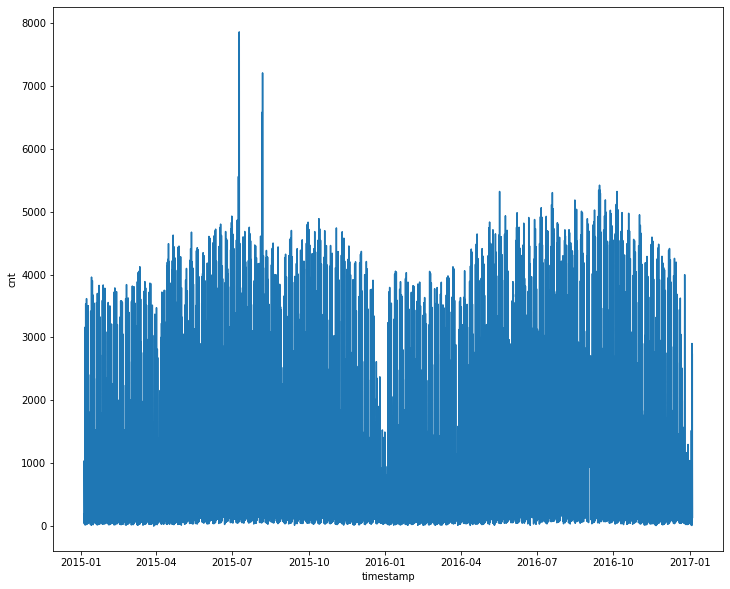

In [208]:
plt.figure(figsize=(12, 10))
sns.lineplot(data=df, x='timestamp', y='cnt')
# Плохо, ничего не понятно, не видно трендов

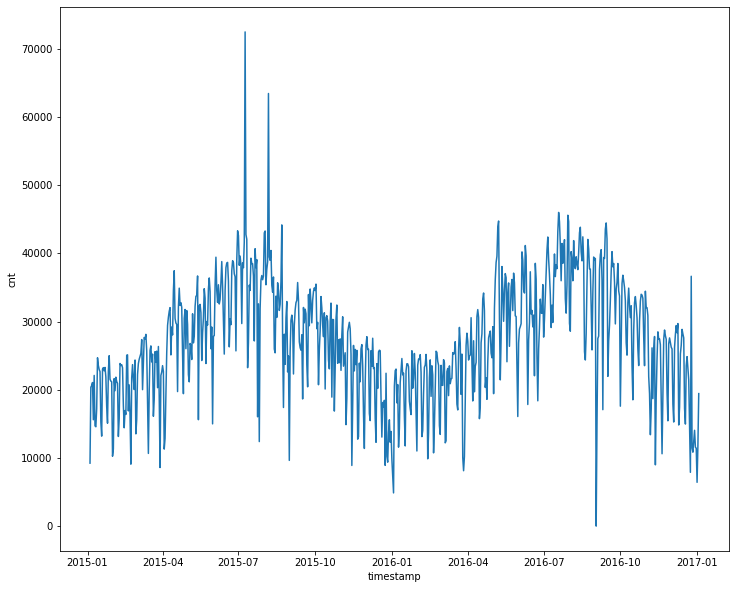

In [209]:
# Поэтому применим метод resample и посчитаем кол-во поездок по дням, а не по часам
df_resampled = df.set_index(df.timestamp).resample(rule='D').cnt.sum().to_frame()
plt.figure(figsize=(12, 10))
sns.lineplot(data=df_resampled, x=df_resampled.index, y='cnt')

In [210]:
df_resampled

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601
...,...
2016-12-30,11566
2016-12-31,11424
2017-01-01,6421


In [212]:
# data averaging with moving mean(MA) - скользящее среднее
# Moving average is a statistical analysis of data points that captures the change in data over time. 
# It calculates a series of averages or arithmetic means of a fixed-sized (or window size) subset from total data observations. 
# You can use a moving average for long term trends, as well as forecasting with limited historical data
# Moving average smooths out the noise in the data and removes ambiguities caused by outliers during data analysis

In [213]:
df_resampled['rolling_mean'] = df_resampled.cnt.rolling(3).mean()
df_resampled

,cnt,rolling_mean
timestamp,,
2015-01-04,9234,NaN
2015-01-05,20372,NaN
2015-01-06,20613,16739.666667
2015-01-07,21064,20683.000000
2015-01-08,15601,19092.666667
...,...,...
2016-12-30,11566,12682.000000
2016-12-31,11424,12347.333333
2017-01-01,6421,9803.666667


In [214]:
df_resampled = df_resampled.reset_index()
df_resampled

,timestamp,cnt,rolling_mean
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667
...,...,...,...
726,2016-12-30,11566,12682.000000
727,2016-12-31,11424,12347.333333
728,2017-01-01,6421,9803.666667
729,2017-01-02,11823,9889.333333


In [215]:
# Filter by date 2015-07-09 (timestamp) using a query can be performed as:
ts = pd.Timestamp
df_resampled.query('timestamp == @ts("20150709")')

,timestamp,cnt,rolling_mean
186,2015-07-09,72504,50705.0


In [216]:
df_resampled['difference'] = df_resampled['cnt'] - df_resampled['rolling_mean']
df_resampled.head()

,timestamp,cnt,rolling_mean,difference
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333
3,2015-01-07,21064,20683.000000,381.000000
4,2015-01-08,15601,19092.666667,-3491.666667


In [217]:
std = np.std(df_resampled['difference'])
std

4558.58664111794

In [218]:
# 99% CI (confidence interval)
df_resampled['upper_bound'] = df_resampled['rolling_mean'] + 2.576 * std
df_resampled['lower_bound'] = df_resampled['rolling_mean'] - 2.576 * std
df_resampled.tail(1).upper_bound.round(2)

730    24302.92
Name: upper_bound, dtype: float64

In [219]:
df_resampled.query('cnt > upper_bound')

,timestamp,cnt,rolling_mean,difference,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
721,2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


In [220]:
df_resampled.query('cnt < lower_bound')

,timestamp,cnt,rolling_mean,difference,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812
